Imported libraries

In [1]:
import pandas as pd

# For Data
from Data.historical_data import Historical_data
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient, StockHistoricalDataClient

# For preprocessing
from Preprocessing.preprocessing import Preprocessing

# For model
from Models.LSTM.lstm import LSTM

# For training and evaluation
from Evaluation.evaluation import Evaluator_LSTM
import time
import matplotlib.pyplot as plt

Data and Preprocessing

In [2]:
new_data = False

if new_data:

    stocks = [['AAPL'], ['MSFT'], ['GOOG'], ['TSLA'], ['NVDA']]

    for stock in stocks:

        timeframes = [TimeFrame.Day, TimeFrame.Hour, TimeFrame.Minute]
        time_strings = ['Day', 'Hour', 'Minute']

        for timeframe, time_string in zip(timeframes, time_strings):

            s_type = "StockBars"
            stock = stock
            timeframe = timeframe
            start = "2020-08-20 06:00:00"
            end = "2021-08-20 06:00:00"
            client = StockHistoricalDataClient("PKV7BABG3DGE0GYL137W", "af1eQghpVgbyX2lh2T9n2ColmVYXHCWndQbKR3Lr")
            save_csv = True
            time_string = time_string

            df = Historical_data(s_type = s_type, stock = stock, timeframe = timeframe, start = start, end = end, client = client, save_csv = save_csv , time_string = time_string)

else:

    df = pd.read_csv('Data\Stock\StockBars\AAPL_Hour')

df_tuple = Preprocessing(df)

      results
0      0.7300
1     -1.9600
2     -1.4700
3      0.7600
4      0.7364
...       ...
4022  -0.0200
4023   0.1300
4024   0.0200
4025   0.0300
4026  -0.0300

[4027 rows x 1 columns]
        open    high     low    close      volume  trade_count        vwap
0     462.70  462.70  461.00  461.700      5270.0        161.0  461.866067
1     461.97  463.85  461.97  463.800      4009.0         93.0  462.890299
2     463.93  465.45  463.72  465.450     14169.0        267.0  464.567499
3     465.40  465.51  464.00  464.640    123527.0       2034.0  464.774981
4     464.64  465.40  463.50  464.000    172447.0       3683.0  464.359567
...      ...     ...     ...      ...         ...          ...         ...
4022  146.81  146.96  145.84  146.835   9440825.0      75232.0  146.424054
4023  146.83  147.30  146.35  146.670  11569246.0      93369.0  146.845036
4024  146.70  146.85  146.43  146.670   8727898.0       2095.0  146.699734
4025  146.68  146.74  146.65  146.650    348260.0        

Create model

In [5]:
input_size = 7 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

lstm_1 = LSTM(input_size, hidden_size, num_layers, df_tuple[0].shape[1]) #our lstm class 

input_size = 7 #number of features
hidden_size = 4 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

lstm_2 = LSTM(input_size, hidden_size, num_layers, df_tuple[0].shape[1]) #our lstm class 

input_size = 7 #number of features
hidden_size = 8 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

lstm_3 = LSTM(input_size, hidden_size, num_layers, df_tuple[0].shape[1]) #our lstm class 

models = [lstm_1, lstm_2, lstm_3]

Train and Evaluate Model

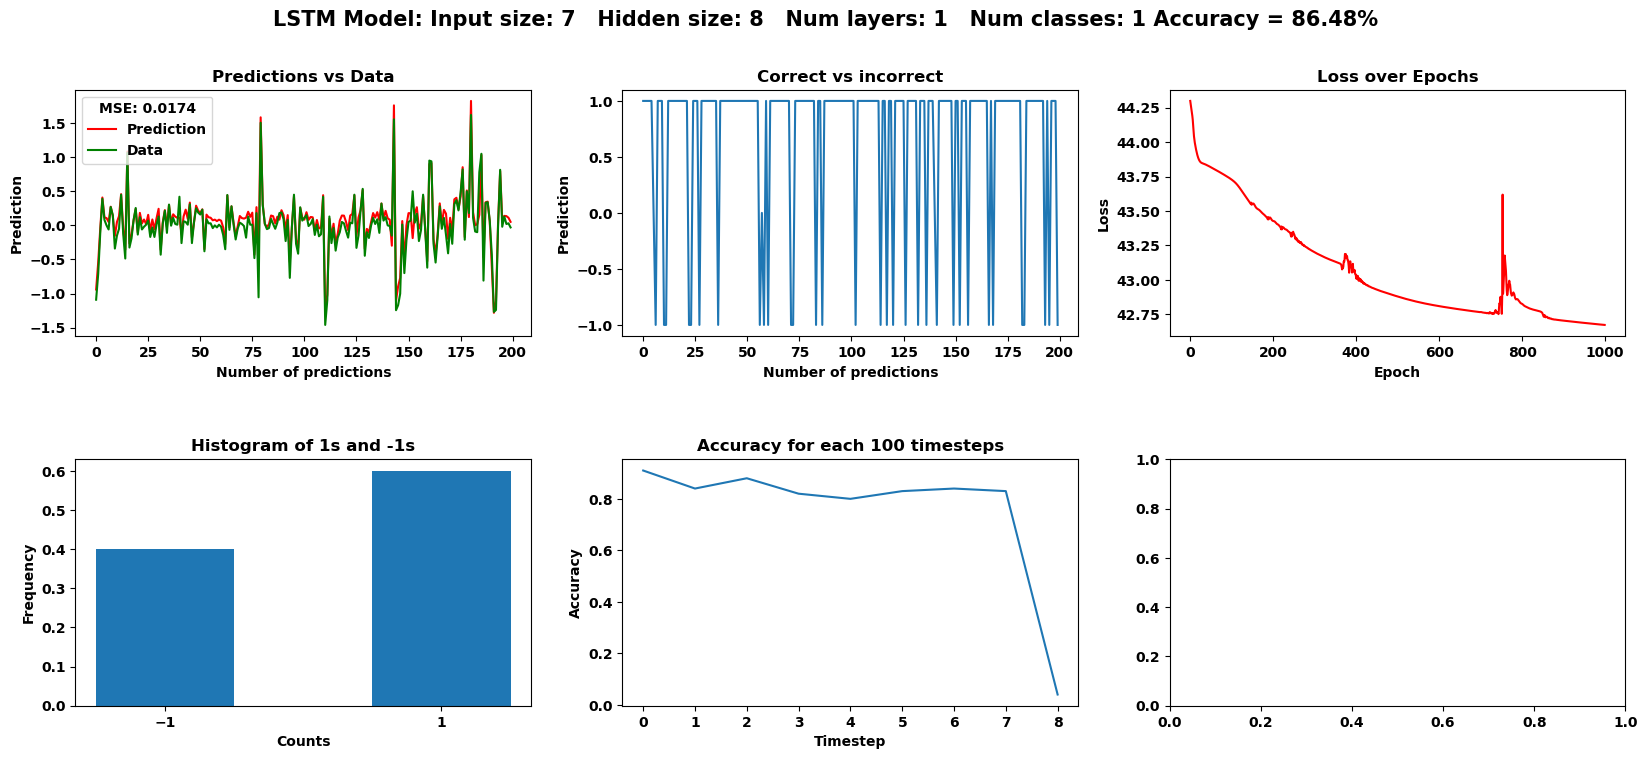

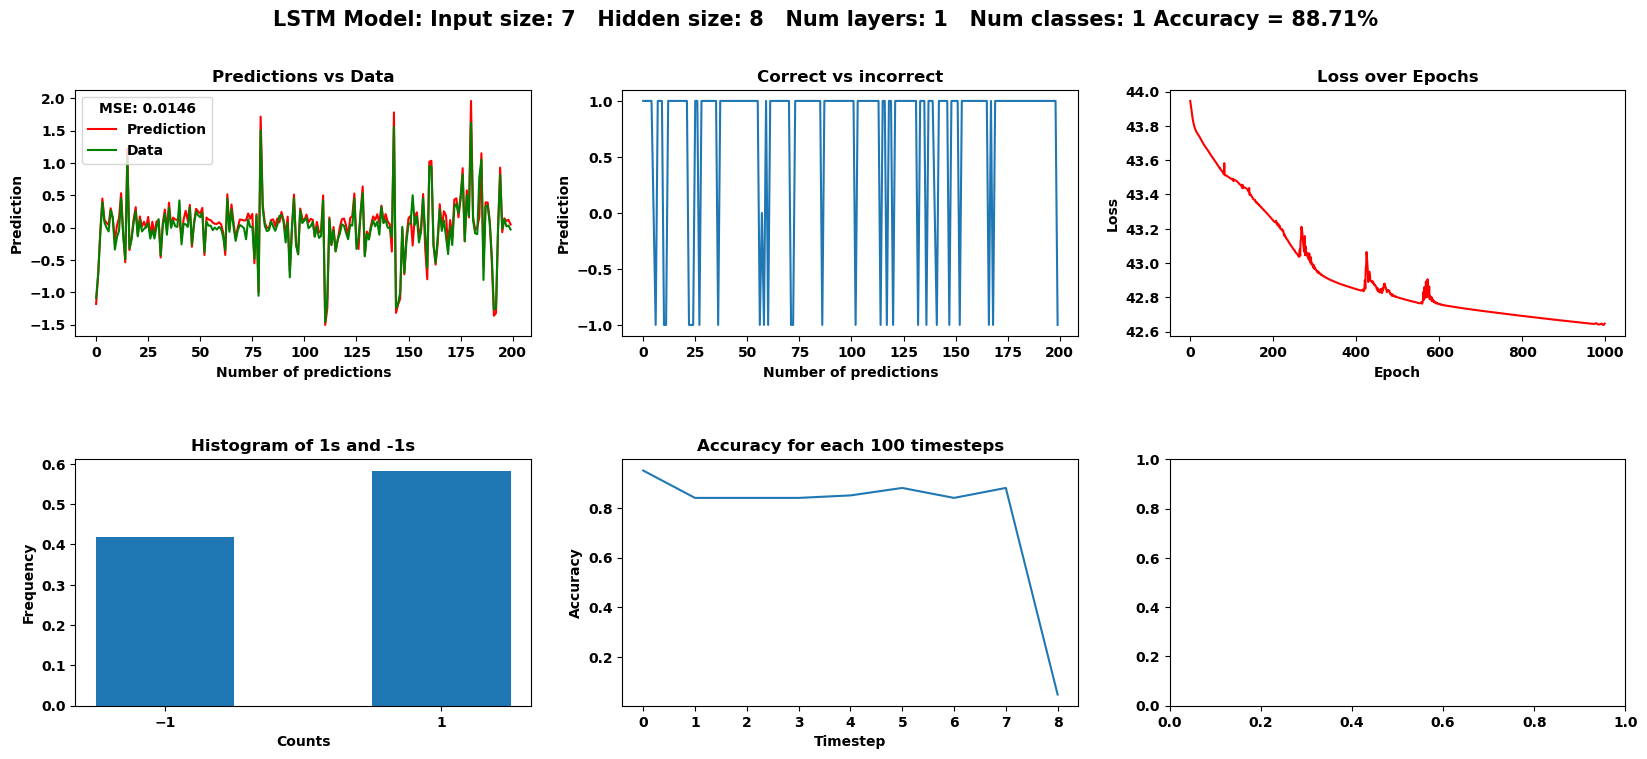

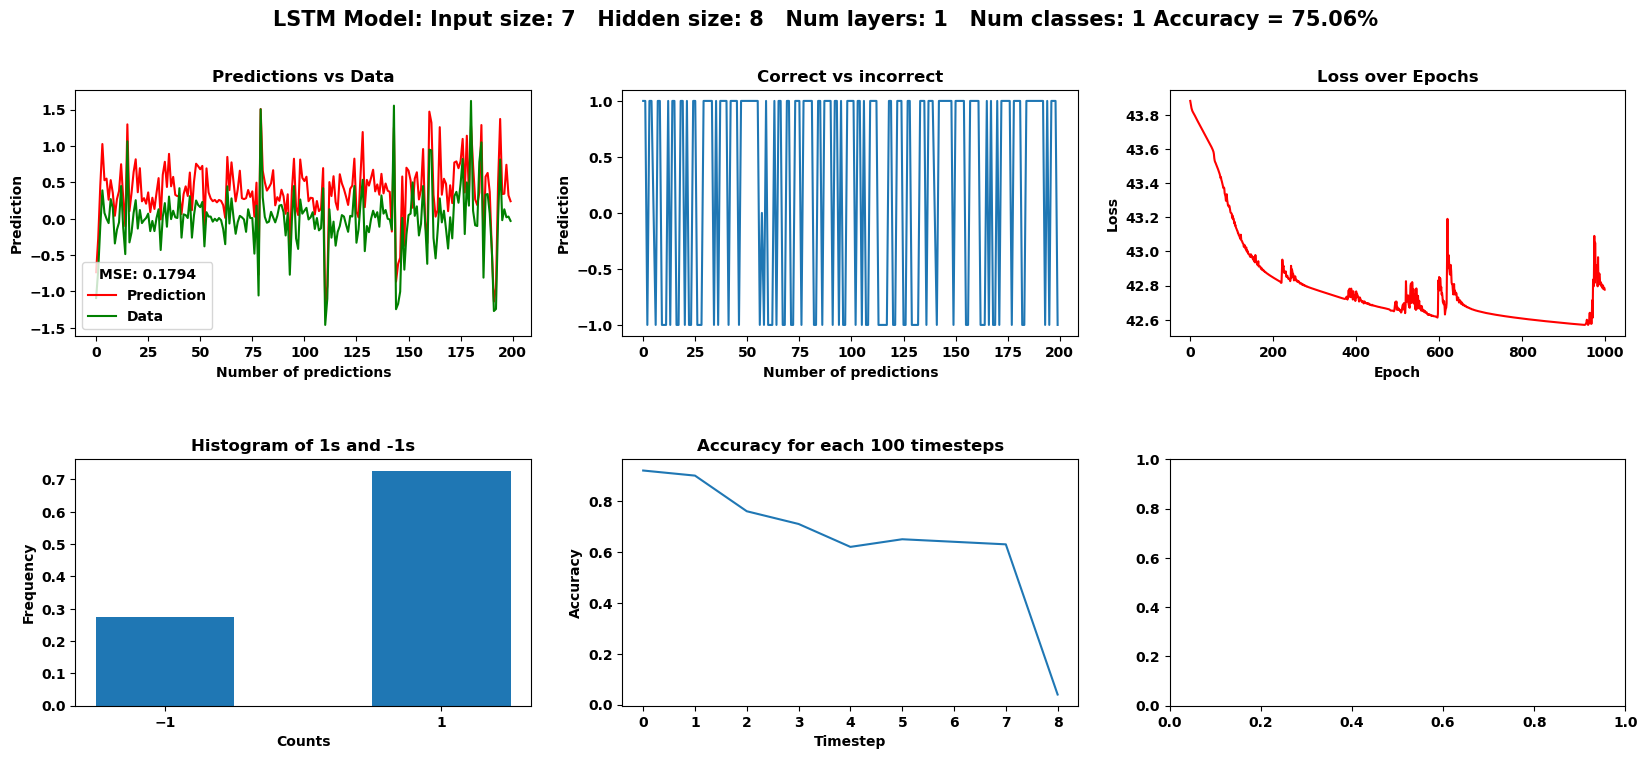

,Model,Loss,Time,Accuracy
0,model_1,42.673290,4.485911,[tensor(0.8648)]
1,model_2,42.645912,5.721594,[tensor(0.8871)]
2,model_3,42.776485,5.971696,[tensor(0.7506)]


In [6]:
model_text = 'Input size: ' + str(input_size) + '   Hidden size: ' + str(hidden_size) + '   Num layers: ' + str(num_layers) + '   Num classes: ' + str(num_classes)
loss_list = []
time_list = []
acc_list = []
for model in models:
    start_time = time.time()
    loss, accuracy= Evaluator_LSTM(model = model, data = df_tuple, learning_rate = 0.01 , num_epochs = 1000, epoch_vis = False, visualize = True, model_text = model_text)
    end_time = time.time()
    time_list.append(end_time - start_time)
    loss_list.append(loss)
    acc_list.append(accuracy)

model_names = ["model_1", "model_2", "model_3"]
df = pd.DataFrame({"Model": model_names, "Loss": loss_list, "Time": time_list, "Accuracy": acc_list})
df
